In [27]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import pandas as pd

# Use biopython library to process fasta files
from Bio import SeqIO

In [2]:
# Process each fasta sample from a given file into a dictionary
# The key is the EPI_ISL_ID, the value is a dictionary with metadata and the protein sequence

def parse_fasta(fasta_filename):
    fasta_entries = SeqIO.parse(fasta_filename, "fasta")
    fasta_samples = {}
    
    for entry in fasta_entries:
        metadata_list = entry.description.split("|")
        protein_sequence = str(entry.seq)

        # Account for rows with missing data
        while len(metadata_list) < 11:
            metadata_list.append("")

        # Remove "hCoV-19/" prefix and remove spaces from fasta strain
        strain = metadata_list[1]
        if strain[:8] == "hCoV-19/":
            strain = strain[8:]
        strain = strain.replace(" ", "")

        # Create dictionary from entry
        sample = {
            "Strain": strain,
            "Submission Date": metadata_list[2],
            "EPI_ISL": metadata_list[3],
            "Division of Exposure": metadata_list[5],
            "Originating Lab": metadata_list[7],
            "Submitting Lab": metadata_list[8],
            "Author": metadata_list[9],
            "Country of Exposure": metadata_list[10],
            "Sequence": protein_sequence,
        }

        # Add sample to fasta_samples
        epi_isl = metadata_list[3]
        assert(epi_isl[:7] == "EPI_ISL")
        fasta_samples[epi_isl] = sample
        
    return fasta_samples

In [3]:
# Process nextstrain global metadata from a given file into a dictionary
# The key is EPI_ISL_ID, the value is a dictionary with global metadata

def parse_nextstrain_metadata(metadata_filename):
    metadata_samples = {}
    
    with open(metadata_filename, "r") as f:
        tsv_reader = csv.reader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
        header = next(tsv_reader)

        for row in tsv_reader:
            # Create dictionary from row
            sample = {}
            for i in range(len(row)):
                sample[header[i]] = row[i]

            # Add sample to metadata_samples
            epi_isl = row[10]
            assert(epi_isl[:7] == "EPI_ISL")
            metadata_samples[epi_isl] = sample
            
    return metadata_samples

In [4]:
# Process GISAID metadata from a given file into a dictionary
# The key is EPI_ISL_ID, the value is a dictionary with GISAID metadata

def parse_gisaid_metadata(metadata_filename):
    metadata_samples = {}
    
    with open(metadata_filename, "r") as f:
        tsv_reader = csv.reader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
        header = next(tsv_reader)
        
        for row in tsv_reader:
            # Remove "hCoV-19/" prefix and remove spaces from strain name
            if row[0][:8] == "hCoV-19/":
                row[0] = row[0][8:]
            row[0] = row[0].replace(" ", "")
            
            # Create dictionary from row
            sample = {}
            for i in range(len(row)):
                sample[header[i]] = row[i]
                
            # Add sample to metadata_samples
            epi_isl = row[2]
            assert(epi_isl[:7] == "EPI_ISL")
            metadata_samples[epi_isl] = sample
            
    return metadata_samples

In [5]:
# Separate nextstrain global timetree data into a tree structure, and an array of timetree entries
# Then, process global timetree entries into a dictionary
# The key is the strain, the value is a dictionary with timetree metadata

def parse_timetree(timetree_filename):
    with open(timetree_filename, "r") as f:
        timetree_str = f.read()
        timetree_str = timetree_str[33:-6] # Remove start and end
        
    # Separate timetree data into a tree structure, and array of timetree entries
    tree_structure = []
    timetree_entries = []
    entry_start_idx = 0
    
    in_strain_name = False
    in_description = False
    in_tree_length = False

    for (i, char) in enumerate(timetree_str):
        # Advance parser state, keeping track of when each tree entry starts and ends
        # Parser state advances from none -> in_strain_name -> in_description -> in_tree_length
        # Separately keep track of the tree structure, using each entry's index in timetree_entries
        if in_strain_name:
            if char == '[':
                in_strain_name = False
                in_description = True

        elif in_description:
            if char == ']':
                in_description = False
                in_tree_length = True

        elif in_tree_length:
            if not char.isdigit() and char != ':' and char != '.':
                in_tree_length = False
                timetree_entries.append(timetree_str[entry_start_idx:i])

                tree_structure.append(str(len(timetree_entries)))
                tree_structure.append(char)

        else:
            if char != ',' and char != '(' and char != ')':
                in_strain_name = True
                entry_start_idx = i
            else:
                tree_structure.append(char)

    tree_structure = "".join(tree_structure)
    
    # Parse timetree entries into a dictionary
    timetree_samples = {}
    
    for (timetree_id, entry) in enumerate(timetree_entries):
        (strain, entry) = entry.split("[&")
        (entry, path_length) = entry.split("]:")
        tokens = entry.split(",")

        # Create dictionary from entry
        sample = {
            "strain": strain,
            "path_length": path_length,
            "timetree_id": timetree_id,
        }
        for token in tokens:
            try:
                (name, value) = token.split("=")
                sample[name] = value
            except ValueError:
                # Handle comma within num_date_CI
                sample["num_date_CI"] += "," + token

        # Add sample to timetree_samples
        timetree_samples[strain] = sample
        
    return (timetree_samples, tree_structure)

In [6]:
# Read in fasta file

fasta_filename = "data/spikeprot0309.fasta"
fasta_samples = parse_fasta(fasta_filename)

print("Number of FASTA entries: ", len(fasta_samples.keys()))
print("\nExample FASTA entry: ")
for (_, value) in fasta_samples.items():
    print(value)
    break

Number of FASTA entries:  702408

Example FASTA entry: 
{'Strain': 'Wuhan/WIV04/2019', 'Submission Date': '2019-12-30', 'EPI_ISL': 'EPI_ISL_402124', 'Division of Exposure': 'hCoV-19^^Hubei', 'Originating Lab': 'Wuhan Jinyintan Hospital', 'Submitting Lab': 'Wuhan Institute of Virology', 'Author': 'Shi', 'Country of Exposure': 'China', 'Sequence': 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLI

In [7]:
# Read in metadata file

metadata_filename = "data/metadata.tsv"
metadata_samples = parse_gisaid_metadata(metadata_filename)

print("Number of metadata entries: ", len(metadata_samples.keys()))
print("\nExample metadata entry: ")
for (_, value) in metadata_samples.items():
    print(value)
    break

Number of metadata entries:  1225793

Example metadata entry: 
{'Virus name': 'Australia/NT12/2020', 'Type': 'betacoronavirus', 'Accession ID': 'EPI_ISL_426900', 'Collection date': '2020', 'Location': 'Oceania / Australia / Northern territory', 'Additional location information': '', 'Sequence length': '29862', 'Host': 'Human', 'Patient age': 'unknown', 'Gender': 'unknown', 'Clade': 'G', 'Pango lineage': 'B.1', 'Pangolin version': '2021-04-21', 'Variant': '', 'AA Substitutions': '(NSP15_A283V,NSP12_P323L,Spike_D614G)', 'Submission date': '2020-04-17', 'Is reference?': '', 'Is complete?': 'True', 'Is high coverage?': 'True', 'Is low coverage?': '', 'N-Content': '0.00691236470311', 'GC-Content': '0.379674275888'}


In [8]:
# Read in timetree file

timetree_filename = "data/nextstrain_ncov_global_timetree.nexus"
(timetree_samples, _) = parse_timetree(timetree_filename)

print("Number of global timetree entries: ", len(timetree_samples.keys()))
print("\nExample global timetree entry: ")
for (_, value) in timetree_samples.items():
    print(value)
    break

Number of global timetree entries:  7354

Example global timetree entry: 
{'strain': 'Wuhan/WH01/2019', 'path_length': '0.0020887245693756995', 'timetree_id': 0, 'clade_membership': '19A', 'num_date': '2019.9849315068493', 'num_date_CI': '{2019.9849315068493,2019.9849315068493}', 'subclade_membership': '19A', 'pango_lineage': 'B', 'GISAID_clade': 'L', 'location': 'Wuhan', 'division': 'Hubei', 'country': 'China', 'region': 'Asia', 'host': 'Human', 'age': '44', 'sex': 'Male', 'recency': 'Older', 'country_exposure': 'China', 'division_exposure': 'Hubei', 'div': '2'}


In [9]:
# Find matches between metadata and fasta data using EPI_ISL_ID

metadata_fasta_matches = []
for epi_isl in metadata_samples.keys():
    if epi_isl in fasta_samples and metadata_samples[epi_isl]["Is complete?"]:
        metadata_fasta_matches.append(epi_isl)
        
print("Number of matching EPI_ISL ID's between GISAID metadata and FASTA: ", len(metadata_fasta_matches))

Number of matching EPI_ISL ID's between GISAID metadata and FASTA:  700872


In [10]:
# Build dictionary of entries that match between metadata and fasta

metadata_fasta_samples = {}
for epi_isl in metadata_fasta_matches:
    fasta = fasta_samples[epi_isl]
    metadata = metadata_samples[epi_isl]
    
    sample = {
        "strain": metadata["Virus name"],
        "clade": metadata["Clade"],
        "pango_lineage": metadata["Pango lineage"],
        "sequence": fasta["Sequence"],
    }
    
    metadata_fasta_samples[epi_isl] = sample

print("Example matched sample: ")
for (_, value) in metadata_fasta_samples.items():
    print(value)
    break

Example matched sample: 
{'strain': 'Australia/NT12/2020', 'clade': 'G', 'pango_lineage': 'B.1', 'sequence': 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGA

In [11]:
# Find matches between timetree and fasta data using strain

# timetree_fasta_matches = []
# for epi_isl in metadata_fasta_matches:
#     strain = metadata_samples[epi_isl]["Strain"]
#     if strain in timetree_samples:
#         timetree_fasta_matches.append(epi_isl)
        
# print("Number of matches between EPI_ISL ID's and NextStrain global timetree: ", len(timetree_fasta_matches))

In [12]:
# Build dictionary of entries that match between all three files

# matched_samples = {}
# for epi_isl in timetree_fasta_matches:
#     fasta = fasta_samples[epi_isl]
#     metadata = metadata_samples[epi_isl]
#     timetree = timetree_samples[metadata["Strain"]]
    
#     sample = {
#         "strain": metadata["Strain"],
#         "divergence": int(timetree["div"]),
#         "clade": timetree["clade_membership"],
#         "subclade": timetree["subclade_membership"],
#         "sequence": fasta["Sequence"],
#     }
    
#     matched_samples[epi_isl] = sample

# print("Example matched sample: ")
# for (_, value) in matched_samples.items():
#     print(value)
#     break

In [13]:
# Map from amino acids, clades, and pango lineage to ints

# Given a dictionary of samples, returns a mapping between entries of <key_name> and int
def get_mapping(key_name, samples_dict):
    all_entries = [value[key_name] for (_, value) in samples_dict.items()]
    mapping_list = sorted(list(set(all_entries)))
    
    mapping_codes = {}
    for (i, v) in enumerate(mapping_list):
        mapping_codes[v] = i
        
    return (mapping_list, mapping_codes)

with open("data/amino_list.txt", encoding="utf8") as f:
    amino_list = f.read().strip().split(',')
amino_codes = {}
for (i, v) in enumerate(amino_list):
    amino_codes[v] = i

(clade_list, clade_codes) = get_mapping("clade", metadata_fasta_samples)
(pango_list, pango_codes) = get_mapping("pango_lineage", metadata_fasta_samples)
    
print("Amino mapping: ", amino_codes)
print("\nClade mapping: ", clade_codes)
print("\nPango mapping: ", pango_codes)

Amino mapping:  {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23, '*': 24}

Clade mapping:  {'G': 0, 'GH': 1, 'GR': 2, 'GRY': 3, 'GV': 4, 'L': 5, 'O': 6, 'S': 7, 'V': 8}

Pango mapping:  {'A': 0, 'A.1': 1, 'A.11': 2, 'A.12': 3, 'A.15': 4, 'A.16': 5, 'A.17': 6, 'A.18': 7, 'A.19': 8, 'A.2': 9, 'A.2.2': 10, 'A.2.3': 11, 'A.2.4': 12, 'A.2.5': 13, 'A.2.5.1': 14, 'A.2.5.2': 15, 'A.21': 16, 'A.22': 17, 'A.23': 18, 'A.23.1': 19, 'A.24': 20, 'A.25': 21, 'A.26': 22, 'A.27': 23, 'A.28': 24, 'A.3': 25, 'A.4': 26, 'A.5': 27, 'A.6': 28, 'A.7': 29, 'A.9': 30, 'AA.1': 31, 'AA.2': 32, 'AA.3': 33, 'AA.4': 34, 'AA.5': 35, 'AA.6': 36, 'AA.7': 37, 'AA.8': 38, 'AB.1': 39, 'AC.1': 40, 'AD.1': 41, 'AD.2': 42, 'AD.2.1': 43, 'AE.1': 44, 'AE.2': 45, 'AE.3': 46, 'AE.4': 47, 'AE.5': 48, 'AE.6': 49, 'AE.7': 50, 'AE.8': 51, 'AF.1': 52, 'AG.1': 53, 'AH.1': 54, 'A

In [14]:
# Convert training and validation data from string to numerical format
    
def amino_to_num(data_list, amino_codes):
    new_data = []
    
    for seq in data_list:
        new_seq = np.array([amino_codes[char] for char in seq])
        new_data.append(new_seq)
        
    return np.array(new_data, dtype=np.object)

# Given a list of labels in string format, and a mapping from string to int, convert the given data to numerical format
def label_to_num(data, mapping):
    new_data = [mapping[label] for label in data]
    return np.array(new_data)

In [15]:
# Generate training and validation datasets
    
train_data = []
train_label_clade = []
train_label_pango = []

validation_data = []
validation_label_clade = []
validation_label_pango = []

for (i, (_, value)) in enumerate(metadata_fasta_samples.items()):
    if i % 10 == 0:
        validation_data.append(value["sequence"])
        validation_label_clade.append(value["clade"])
        validation_label_pango.append(value["pango_lineage"])
    else:
        train_data.append(value["sequence"])
        train_label_clade.append(value["clade"])
        train_label_pango.append(value["pango_lineage"])
        
train_data_num = amino_to_num(train_data, amino_codes)
train_label_clade_num = label_to_num(train_label_clade, clade_codes)
train_label_pango_num = label_to_num(train_label_pango, pango_codes)

validation_data_num = amino_to_num(validation_data, amino_codes)
validation_label_clade_num = label_to_num(validation_label_clade, clade_codes)
validation_label_pango_num = label_to_num(validation_label_pango, pango_codes)

In [16]:
# Print sample data

print("Sample data: ", train_data[0][:500])
print("\nSample data numerical: \n", train_data_num[0][:500])
print("\nSample label clade: ", train_label_clade[0])
print("Sample label clade numerical: ", train_label_clade_num[0])
print("\nSample label pango: ", train_label_pango[0])
print("Sample label pango numerical: ", train_label_pango_num[0])

Sample data:  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPT

Sample data numerical: 
 [11  5 19  5 10 19 10 10 13 10 19 16 16 14  2 19 12 10 17 17 15 17 14 10
 13 13  0 22 17 12 16  5 17 15  6 19 22 22 13  3  9 19  5 15 16 16 19 10
  7 16 17 14  3 10  5 10 13  5  5 16 12 19 17 20  5  7  0  8  7 19 16  6
 17 12  6 17  9 15  5  3 12 13 19 10 13  5 12  3  6 19 22  5  0 16 17  4
  9 16 12  8  8 15  6 20  8  5  6 17 17 10  3 16  9 17 14 16 10 10  8 19
 12 12  0 17 12 19 19  8  9 19  2  4  5 14  5  2 12  3 13  5 10  6 19 22
 22  7  9 12 12  9 16

In [36]:
# Save all data to numpy file

# np.save("data/matched_samples.npy", matched_samples, allow_pickle=True)
# np.save("data/fasta_samples.npy", fasta_samples, allow_pickle=True)
# np.save("data/metadata_samples.npy", metadata_samples, allow_pickle=True)
# np.save("data/timetree_samples.npy", timetree_samples, allow_pickle=True)

np.save("data/amino_mapping.npy", amino_list, allow_pickle=True)
np.save("data/clade_mapping.npy", clade_list, allow_pickle=True)
np.save("data/pango_mapping.npy", pango_list, allow_pickle=True)

np.save("data/train_data.npy", train_data, allow_pickle=True)
np.save("data/train_data_num.npy", train_data_num, allow_pickle=True)
np.save("data/train_label_clade.npy", train_label_clade, allow_pickle=True)
np.save("data/train_label_clade_num.npy", train_label_clade_num, allow_pickle=True)
np.save("data/train_label_pango.npy", train_label_pango, allow_pickle=True)
np.save("data/train_label_pango_num.npy", train_label_pango_num, allow_pickle=True)

np.save("data/validation_data.npy", validation_data, allow_pickle=True)
np.save("data/validation_data_num.npy", validation_data_num, allow_pickle=True)
np.save("data/validation_label_clade.npy", validation_label_clade, allow_pickle=True)
np.save("data/validation_label_clade_num.npy", validation_label_clade_num, allow_pickle=True)
np.save("data/validation_label_pango.npy", validation_label_pango, allow_pickle=True)
np.save("data/validation_label_pango_num.npy", validation_label_pango_num, allow_pickle=True)

Text(0,0.5,'Count')

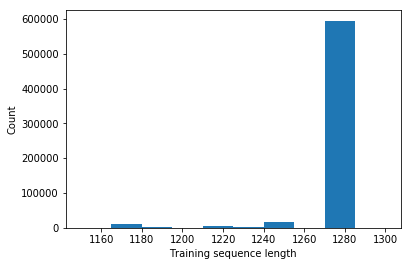

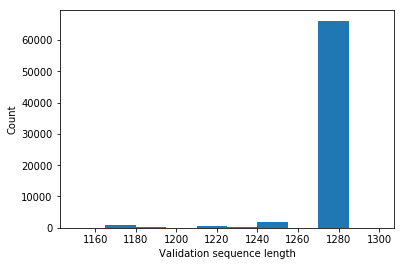

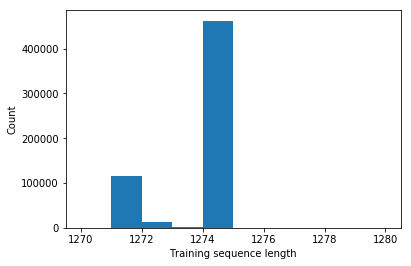

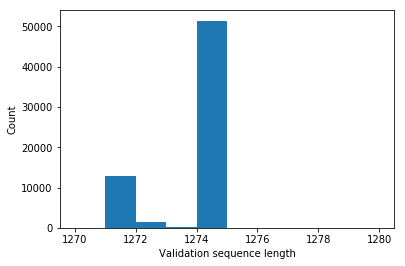

In [26]:
# Output histogram of sequence lengths

train_data_lengths = [len(row) for row in train_data_num]
validation_data_lengths = [len(row) for row in validation_data_num]

# Training sequence length
plt.figure()
plt.hist(train_data_lengths, range=(1150,1300))
plt.xlabel("Training sequence length")
plt.ylabel("Count")

# Validation sequence length
plt.figure()
plt.hist(validation_data_lengths, range=(1150,1300))
plt.xlabel("Validation sequence length")
plt.ylabel("Count")

# Training sequence length
plt.figure()
plt.hist(train_data_lengths, range=(1270,1280))
plt.xlabel("Training sequence length")
plt.ylabel("Count")

# Validation sequence length
plt.figure()
plt.hist(validation_data_lengths, range=(1270,1280))
plt.xlabel("Validation sequence length")
plt.ylabel("Count")

Training clade label:
1    147661
2    138280
3    115324
4    114594
0     88610
7      8837
6      6957
8      5695
5      4826
Name: label, dtype: int64
Validation clade label:
1    16500
2    15363
3    12825
4    12665
0     9881
7      936
6      758
8      622
5      538
Name: label, dtype: int64
Training pango lineage label:
453     121234
72       51058
556      50946
658      37362
73       31582
517      13363
1228     11437
568       9197
171       7824
716       7458
679       7190
228       6941
910       6482
705       5402
620       5144
Name: label, dtype: int64
Validation pango lineage label:
453     13464
72       5702
556      5610
658      4206
73       3468
517      1550
1228     1263
568       985
171       845
679       837
716       831
228       802
910       703
705       598
620       557
Name: label, dtype: int64


Text(0,0.5,'Count')

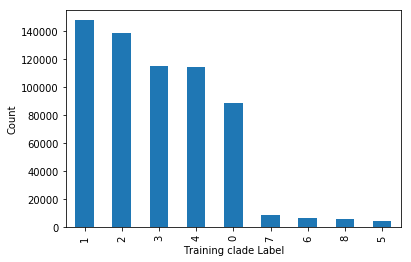

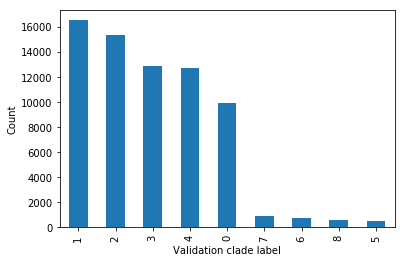

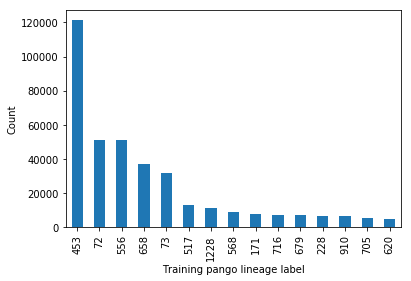

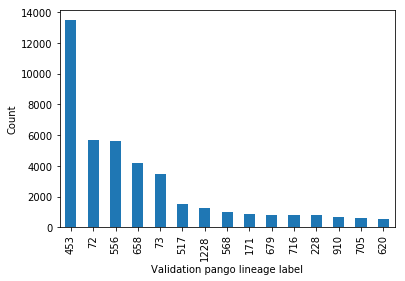

In [42]:
# Output bar charts of label frequencies

# Training clade frequencies
plt.figure()
df = pd.DataFrame({"data": train_data_num, "label": train_label_clade_num})
counts = df["label"].value_counts()
print("Training clade label:")
print(counts)
counts.plot(kind="bar")
plt.xlabel("Training clade Label")
plt.ylabel("Count")

# Validation clade frequencies
plt.figure()
df = pd.DataFrame({"data": validation_data_num, "label": validation_label_clade_num})
counts = df["label"].value_counts()
print("Validation clade label:")
print(counts)
counts.plot(kind="bar")
plt.xlabel("Validation clade label")
plt.ylabel("Count")

# Training pango lineage frequencies
plt.figure()
df = pd.DataFrame({"data": train_data_num, "label": train_label_pango_num})
counts = df["label"].value_counts()[:15]
print("Training pango lineage label:")
print(counts)
counts.plot(kind="bar")
plt.xlabel("Training pango lineage label")
plt.ylabel("Count")

# Validation pango lineage frequencies
plt.figure()
df = pd.DataFrame({"data": validation_data_num, "label": validation_label_pango_num})
counts = df["label"].value_counts()[:15]
print("Validation pango lineage label:")
print(counts)
counts.plot(kind="bar")
plt.xlabel("Validation pango lineage label")
plt.ylabel("Count")